In [1]:
import os
import sys
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader


data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_mag_3x3/measurements


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)

        N, H = self.num_visible, self.num_hidden
        return torch.split(x, [N, N, H, H], dim=-1)


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.initialize_weights(w_std=0.1)

        self.conditioner = Conditioner(num_visible=num_visible, num_hidden=num_hidden,
                                       cond_dim=cond_dim, hidden_width=conditioner_width)

    def initialize_weights(self, w_mean: float = 0.0, w_std: float = 0.1, bias_val: float = 0.0):
        nn.init.normal_(self.W, mean=w_mean, std=w_std)
        nn.init.constant_(self.b, bias_val)
        nn.init.constant_(self.c, bias_val)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=W.dtype, device=W.device)    # v can come in dtype int or bool

        # broadcasting handles (Batch, N) * (1, N) automatically
        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(v @ W + c).sum(dim=-1)
        return term1 - term2

    def _compute_effective_biases(self, cond: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)

        # explicit unsqueeze(0) ensures we broadcast correctly against the batch dimension
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)

        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        v_next = torch.bernoulli(p_v, generator=rng)
        return v_next

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        fe = self._free_energy(v, self.W, b_mod, c_mod)
        return -0.5 * fe / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        values, _, cond = batch
        v_data = values.to(dtype=self.W.dtype, device=self.W.device)

        rng = aux_vars.get("rng", torch.Generator(device="cpu"))
        l2_strength = float(aux_vars.get("l2_strength", 0.0))
        noise_frac = float(aux_vars.get("noise_frac", 0.05))

        # condition biases and regularize large deviations from base biases
        cond = cond.to(v_data.device, dtype=v_data.dtype)
        b_mod, c_mod = self._compute_effective_biases(cond)
        l2_reg = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        # start chains from data like in vanilla CD
        v_model = v_data.clone()

        # overwrite a fraction with uniform noise
        batch_size = v_data.shape[0]
        n_noise = int(batch_size * noise_frac)
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        # run gibbs steps
        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, self.T, rng)

        v_model = v_model.detach()

        # count bit flips of model vs chain start (data), not very useful for noisy inits
        n_flips = (v_data != v_model).float().sum()
        flip_rate = n_flips / v_data.numel()

        # track other useful stats
        max_bias = torch.max(torch.abs(b_mod)).detach()
        mag_model = v_model.float().mean()

        # compose loss from free energy difference and regularization
        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_diff = fe_data - fe_model

        loss = fe_diff.mean() + l2_strength * l2_reg

        fe_mean = fe_diff.mean().detach()
        fe_std = fe_diff.std(unbiased=False).detach()

        return loss, {
            "free_energy_mean": fe_mean,
            "free_energy_std": fe_std,
            "flip_rate": flip_rate,
            "max_bias": max_bias,
            "mag_model": mag_model
        }

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        B = cond.shape[0]

        # allow to pass a 1D condition and a scalar temperature schedule
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)

        if T_schedule.dim() == 0:
            T_schedule = T_schedule.view(1)

        cond = cond.to(next(self.parameters()).device, dtype=torch.float32)

        b_mod, c_mod = self._compute_effective_biases(cond)

        # for new samples we initialize from uniform noise
        probs = torch.full((B, self.num_visible), 0.5, device=cond.device, dtype=torch.float32)
        v = torch.bernoulli(probs, generator=rng)

        for i in range(int(T_schedule.shape[0])):
            v = self._gibbs_step(v, b_mod, c_mod, float(T_schedule[i]), rng)

        return v

In [3]:
# OBSERVABLES (TFIM SPECIFIC)

def compute_mz_abs(samples: torch.Tensor) -> Tuple[float, float]:
    spins_pm = 1.0 - 2.0 * samples.float()
    mz_per_sample = spins_pm.mean(dim=1)

    mz_abs = mz_per_sample.abs()

    total_mz = mz_abs.mean().item()
    total_mz_err = mz_abs.std(unbiased=True).item() / math.sqrt(samples.shape[0])

    return total_mz, total_mz_err


def compute_mx(samples: torch.Tensor, log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> Tuple[float, float]:

    B, N = samples.shape

    with torch.no_grad():
        log_scores_orig = log_score_fn(samples)

        total_ratios = torch.zeros(B, device=samples.device, dtype=torch.float32)

        # iterate over all sites and compute flip ratios over whole batch
        for i in range(N):
            flipped_samples = samples.clone()
            flipped_samples[:, i] = 1 - flipped_samples[:, i]

            log_scores_flip = log_score_fn(flipped_samples)

            log_ratios = log_scores_flip - log_scores_orig
            total_ratios += torch.exp(log_ratios)

        avg_mx_per_sample = total_ratios / N

        total_mx = avg_mx_per_sample.mean().item()
        total_mx_err = avg_mx_per_sample.std(unbiased=True).item() / math.sqrt(B)

        return total_mx, total_mx_err


# Mx is the indicator of quantumness, we want it to stabilize.
def monitor_mx(model, ds, device, seed: int):
    model.eval()

    rng = torch.Generator()
    rng.manual_seed(seed)

    num_samples = len(ds)
    n_monitor = min(1000, num_samples)
    indices = torch.randint(0, num_samples, (n_monitor,), generator=rng)

    samples = torch.as_tensor(ds.values[indices], device=device)
    cond = torch.as_tensor(ds.system_params[indices], device=device, dtype=torch.float32)

    scorer = lambda v: model.log_score(v, cond)

    mx_val, _ = compute_mx(samples, scorer)

    model.train()
    return mx_val

In [4]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, List[Tuple[str, ...]], Optional[torch.Tensor]], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux

def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int, rng: torch.Generator,
          monitor_seed: int, l2_strength: float, noise_frac: float, lr_schedule_fn: Callable[[int], float],
          ds: MeasurementDataset):

    metrics: Dict[int, Any] = {}
    global_step = 0
    device = next(model.parameters()).device

    header = f"{'Epoch':<6} | {'Loss':<9} | {'FE STD':<8} | {'Flips':<6} | {'MaxBias':<7} | {'LR':<8} | {'Mx':<8}"
    print(header)
    print("-" * len(header))

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean_last = torch.tensor(0.0)
        fe_std_last = torch.tensor(0.0)

        avg_flip = 0.0
        max_bias_epoch = 0.0

        avg_raw_mag = 0.0

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "rng": rng, "l2_strength": l2_strength, "noise_frac": noise_frac }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean_last = aux_out.get("free_energy_mean", torch.tensor(0.0))
            fe_std_last = aux_out.get("free_energy_std", torch.tensor(0.0))

            avg_flip += float(aux_out.get("flip_rate", 0.0))
            max_bias_epoch = max(max_bias_epoch, float(aux_out.get("max_bias", 0.0)))
            avg_raw_mag += float(aux_out.get("mag_model", 0.0))

            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))
        avg_flip_pct = (avg_flip / len(loader)) * 100.0
        avg_raw_mag /= len(loader)

        mx_curr = monitor_mx(model, ds, device, seed=monitor_seed)

        metrics[epoch] = dict(loss=avg_loss, free_energy_mean=float(fe_mean_last),
                              free_energy_var=float(fe_std_last), lr=lr_epoch, mx=mx_curr)

        print(f"{epoch + 1:<6} | {avg_loss:+.4f}   | {float(fe_std_last):.4f}   | {avg_flip_pct:5.2f}% |"
              f" {max_bias_epoch:5.2f}   | {lr_epoch:.5f}  | {mx_curr:.5f}")

    return model, metrics

def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None: center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

In [5]:
# DATA LOADING

SIDE_LENGTH = 3
FILE_SAMPLES = 5_000_000
TRAIN_SAMPLES = 10_000

h_support = [1.00, 2.00, 2.80, 3.00, 3.30, 3.60, 4.00, 5.00, 6.00, 7.00]
file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLES}.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]
samples_per_file = [TRAIN_SAMPLES] * len(file_paths)

print(f"System Size       : {SIDE_LENGTH}x{SIDE_LENGTH} ({SIDE_LENGTH**2} qubits)")
print(f"Training Samples  : {TRAIN_SAMPLES} per file")
print(f"Support Fields (h): {h_support}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["h"], samples_per_file=samples_per_file)

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 3x3 (9 qubits)
Training Samples  : 10000 per file
Support Fields (h): [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]
Samples Shape     : (100000, 9)
Conditions Shape  : (100000, 1)


In [6]:
# TRAINING CONFIG

# the TFIM state is quite easy to learn

batch_size        = 1024
num_visible       = ds.num_qubits

num_hidden        = 9
conditioner_width = 32
l2_strength       = 0.0
num_epochs        = 20
k_steps           = 100
init_lr           = 1e-2
final_lr          = init_lr * 0.1
noise_frac        = 1.0     # starting from noise is important for Mx

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)

model.initialize_weights(w_mean=0.0, w_std=0.01, bias_val=0.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.005)

model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       rng=rng, monitor_seed=SEED, l2_strength=l2_strength, noise_frac=noise_frac,
                       lr_schedule_fn=lr_schedule_fn, ds=ds)

Epoch  | Loss      | FE STD   | Flips  | MaxBias | LR       | Mx      
----------------------------------------------------------------------
1      | -0.0183   | 0.6760   | 49.98% |  0.95   | 0.00989  | 0.92177
2      | -0.2336   | 1.9675   | 49.96% |  2.19   | 0.00982  | 0.83303
3      | -0.1048   | 2.0541   | 50.10% |  2.05   | 0.00972  | 0.82782
4      | -0.0466   | 1.9010   | 49.91% |  2.08   | 0.00955  | 0.82586
5      | -0.0265   | 1.9875   | 49.95% |  2.19   | 0.00929  | 0.82540
6      | -0.0005   | 1.8119   | 50.12% |  2.25   | 0.00889  | 0.82493
7      | -0.0148   | 1.8946   | 50.03% |  2.25   | 0.00832  | 0.82432
8      | -0.0057   | 2.0437   | 50.02% |  2.41   | 0.00754  | 0.82480
9      | -0.0046   | 1.8758   | 50.12% |  2.28   | 0.00658  | 0.82454
10     | +0.0018   | 1.7539   | 50.09% |  2.26   | 0.00550  | 0.82393
11     | -0.0028   | 1.8184   | 50.01% |  2.22   | 0.00442  | 0.82412
12     | -0.0044   | 1.9120   | 50.11% |  2.27   | 0.00346  | 0.82376
13     | +0.0016  

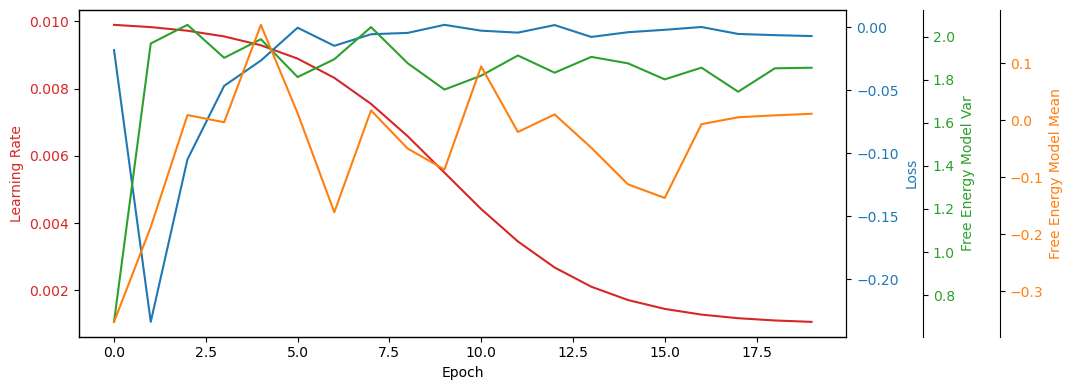

In [7]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [8]:
# EVALUATION

h_novel = [1.5, 2.4, 2.6, 2.9, 3.1, 3.2, 3.4, 3.8, 4.5, 5.5, 6.5]
sweep = sorted([(h, "support") for h in h_support] + [(h, "novel") for h in h_novel], key=lambda x: x[0])

T_eval = 1.0
eval_samples = 10_000

rng_eval = torch.Generator().manual_seed(1234)

print("=== EVALUATION SWEEP =========================================")
print(f"Estimating |Mz| and Mx.")
print(f"Total points: {len(sweep)}")
print("==============================================================")

results = []

for h_val, kind in sweep:
    cond_single = torch.tensor([[h_val]], device=next(model.parameters()).device, dtype=torch.float32)
    cond_batch = cond_single.expand(eval_samples, -1)

    T_schedule = torch.full((model.k,), T_eval, device=cond_batch.device)
    samples = model.generate(cond_batch, T_schedule, rng_eval)

    scorer = lambda v: model.log_score(v, cond_batch)

    mz, _ = compute_mz_abs(samples)
    mx, _ = compute_mx(samples, scorer)

    results.append({"h": h_val, "type": kind, "mz": mz, "mx": mx})
    print(f"h {h_val:5.2f} [{kind:7}] | |Mz|: {mz:.5f} | Mx: {mx:.5f}")

df = pd.DataFrame(results).sort_values("h")

=== EVALUATION SWEEP =========================================
Estimating |Mz| and Mx.
Total points: 21
h  1.00 [support] | |Mz|: 0.96078 | Mx: 0.27580
h  1.50 [novel  ] | |Mz|: 0.93700 | Mx: 0.34044
h  2.00 [support] | |Mz|: 0.83073 | Mx: 0.53968
h  2.40 [novel  ] | |Mz|: 0.69442 | Mx: 0.71669
h  2.60 [novel  ] | |Mz|: 0.63698 | Mx: 0.78086
h  2.80 [support] | |Mz|: 0.58191 | Mx: 0.83295
h  2.90 [novel  ] | |Mz|: 0.56256 | Mx: 0.84782
h  3.00 [support] | |Mz|: 0.54007 | Mx: 0.86752
h  3.10 [novel  ] | |Mz|: 0.52727 | Mx: 0.87576
h  3.20 [novel  ] | |Mz|: 0.50633 | Mx: 0.89390
h  3.30 [support] | |Mz|: 0.49187 | Mx: 0.90401
h  3.40 [novel  ] | |Mz|: 0.48267 | Mx: 0.91045
h  3.60 [support] | |Mz|: 0.45522 | Mx: 0.92951
h  3.80 [novel  ] | |Mz|: 0.43662 | Mx: 0.94098
h  4.00 [support] | |Mz|: 0.41936 | Mx: 0.95037
h  4.50 [novel  ] | |Mz|: 0.39329 | Mx: 0.96462
h  5.00 [support] | |Mz|: 0.36556 | Mx: 0.97710
h  5.50 [novel  ] | |Mz|: 0.34889 | Mx: 0.98273
h  6.00 [support] | |Mz|: 0.3435

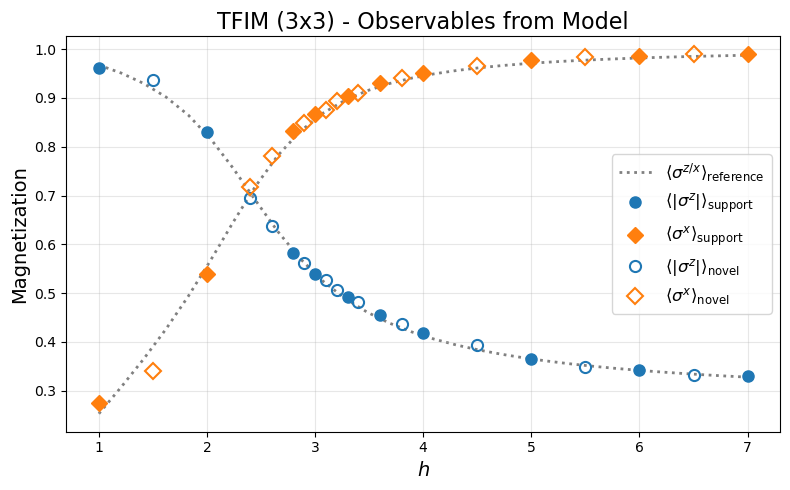

In [9]:
ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnetizations_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

supp = df[df["type"] == "support"]
nov = df[df["type"] == "novel"]

plt.figure(figsize=(8, 5))

if ref_df is not None:
    plt.plot(ref_df["h"], ref_df["mag_z"], ':', color='gray', linewidth=2.0, label='_nolegend_', zorder=1)
    plt.plot(ref_df["h"], ref_df["mag_x"], ':', color='gray', linewidth=2.0,
             label=r'$\langle \sigma^{z/x} \rangle_{\mathrm{reference}}$', zorder=1)

plt.plot(supp["h"], supp["mz"], 'o', color='C0', markersize=8,
         label=r'$\langle | \sigma^z | \rangle_{\mathrm{support}}$', zorder=2)
plt.plot(supp["h"], supp["mx"], 'D', color='C1', markersize=8,
         label=r'$\langle \sigma^x \rangle_{\mathrm{support}}$', zorder=2)

plt.plot(nov["h"], nov["mz"], 'o', color='C0', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle | \sigma^z | \rangle_{\mathrm{novel}}$', zorder=2)
plt.plot(nov["h"], nov["mx"], 'D', color='C1', markerfacecolor='none',
         markersize=8, markeredgewidth=1.5, label=r'$\langle \sigma^x \rangle_{\mathrm{novel}}$', zorder=2)

plt.xlabel(r'$h$', fontsize=14)
plt.ylabel('Magnetization', fontsize=14)
plt.title(f"TFIM ({SIDE_LENGTH}x{SIDE_LENGTH}) - Observables from Model", fontsize=16)

plt.legend(frameon=True, fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_magnetizations_rbm.csv"
df.to_csv(file_name, index=False, float_format="%.6f")
print(f"\nSaved RBM magnetizations to: {os.path.abspath(file_name)}")


Saved RBM magnetizations to: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_mag_3x3/tfim_3x3_magnetizations_rbm.csv
